## Inverse Cooking: Recipe Generation from Food Images

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '../data'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab_orig.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab_orig.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [5]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [42]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
#model_path = os.path.join('../checkpoints/inversecooking/model/checkpoints/model_recipetitleonly.ckpt')
model_path = os.path.join('../data/modelbest_orig.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/Users/stevezheng/Desktop/OMSA/Fall 2023/Project/gastroml/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/stevezheng/Desktop/OMSA/Fall 2023/Project/gastroml/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/stevezheng/Desktop/OMSA/Fall 2023/Project/gastroml/venv/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 1.1402571201324463


In [8]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [9]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [10]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

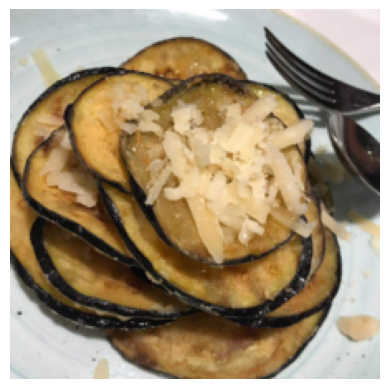

RECIPE 1

Title: Grilled eggplant and zucchini

Ingredients:
zucchini, oil, salt, eggplant, pepper

Instructions:
-Preheat grill to medium-high.
-Brush eggplant slices with oil and season with salt and pepper.
-Grill, turning once, until tender and lightly charred, about 10 minutes.
-Transfer to a platter and let cool.
-Cut into 1/2-inch slices.
-Serve warm.
RECIPE 2

Title: Roasted eggplant, zucchini and olive oil

Ingredients:
zucchini, oil, salt, eggplant, pepper

Instructions:
-Cut the zucchini into 1/2-inch thick slices.
-Arrange on a baking sheet.
-Drizzle with 2 tablespoons olive oil or butter.
-Sprinkle with salt and pepper, then toss.
-Roast in a 400 degree f oven for 40 - 50 minutes, turning once, until golden brown and tender.
RECIPE 3

Title: Grilled eggplant with zucchini (aubergine)

Ingredients:
zucchini, oil, salt, eggplant, pepper

Instructions:
-Light a grill.
-Cut the eggplant into 1-inch thick slices.
-In a medium bowl toss the eggplant slices with the oil, salt and

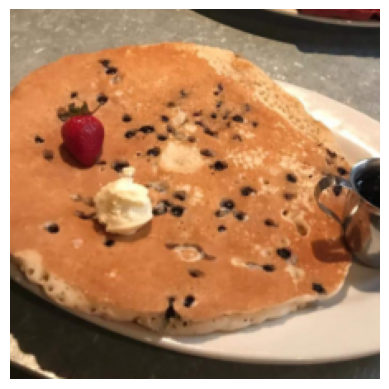

RECIPE 1

Title: Easy pancakes

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, oil

Instructions:
-Mix all ingredients together.
-Heat skillet and pour 1/4 cup of batter onto skillet.
-Cook until bubbles form on top.
-Flip and cook until golden brown.
RECIPE 2

Title: Crepes with brown sugar and butter

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, oil

Instructions:
-Preheat griddle.
-Combine flour, baking powder, and salt and mix well.
-Beat in milk, eggs, and butter until smooth.
-Pour about 1/4 cup batter onto griddle for each crepe and cook until bubbles form on surface.
-Turn crepe and cook until underside is golden.
-Serve warm with powdered sugar, syrup or butter.
RECIPE 3

Title: Easy crepes

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, oil

Instructions:
-Beat eggs in a bowl with mixer until thick and fluffy; add milk, 1 tablespoon at a time, beating well after each addition.
-In a separate bowl whisk together flo

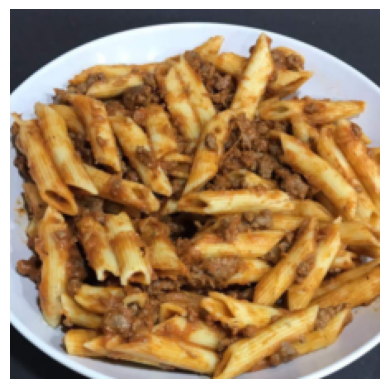

RECIPE 1

Title: Penne with caramelized onions

Ingredients:
cheese, pasta, pepper, onion, oil

Instructions:
-Heat oil in large skillet over medium-high heat.
-Add onions; cook until golden brown, stirring occasionally, about 15 minutes.
-Add pasta and cook until heated through, stirring occasionally, about 10 minutes.
-Season with salt and pepper.
-Sprinkle with cheese.
RECIPE 2

Title: Cheesy pasta sauce and pasta

Ingredients:
cheese, pasta, pepper, onion, oil

Instructions:
-Heat a large pan with a little oil and saute onion until tender but not brown.
-Add pasta and cook to al dente and drain.
-Add sauce to pasta and cook for 2 minutes until heated through.
-Sprinkle cheese over pasta and serve immediately.
-Buon appetito !
RECIPE 3

Title: Rigatoni

Ingredients:
cheese, pasta, pepper, onion, oil

Instructions:
-Boil rigatoni according to package directions; drain.
-Meanwhile, saute onion in oil, until tender.
-Add drained rigatoni to onion.
-Add ricotta and 1/2 cup mozzarella, s

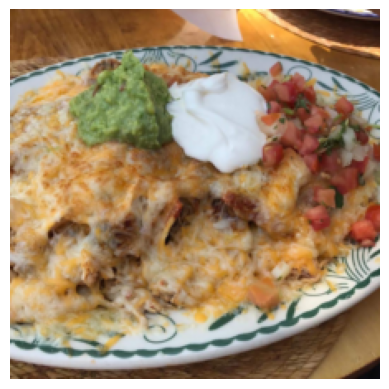

RECIPE 1

Title: Chicken enchiladas

Ingredients:
cheese, tortilla, onion, cream, enchilada_sauce, chicken, chili, beans, pepper, tomato, cumin

Instructions:
-Preheat oven to 350 degrees.
-In a large bowl, combine chicken, beans, tomatoes, onion, green chilies, cumin, and chili powder.
-Spoon about 1/4 cup of the chicken mixture down the center of each tortilla.
-Roll up and place seam side down in a greased 13x9 baking dish.
-Pour enchilada sauce over enchiladas.
-Sprinkle with cheese.
-Bake uncovered for 20 minutes.
RECIPE 2

Title: Green chile chicken enchiladas

Ingredients:
cheese, tortilla, onion, cream, enchilada_sauce, chicken, chili, beans, pepper, tomato, cumin

Instructions:
-In small bowl combine the first 5 ingredients.
-Spoon 1/3 cup chicken mixture down center of each tortilla; roll up.
-Place, seam sides down, in 13x9-inch baking dish sprayed with cooking spray.
-Top with remaining chicken mixture.
-Sprinkle with cheese; cover.
-Bake at 350f for 25 minutes or until hea

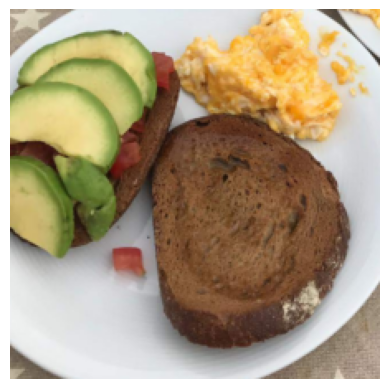

RECIPE 1

Title: Avocado egg salad sandwich

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Toast bread.
-Spread mayonnaise on one side of each slice.
-Place avocado slices on one slice of bread.
-Top with tomato slices and salt and pepper.
-Top with other slice of bread.
RECIPE 2

Title: Avocado and tomato sandwich

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Heat a pan with vegetable oil.
-Toast the bread.
-Slice the tomato.
-Mash the avocado in a bowl.
-Add the mayonnaise and salt and pepper.
-Mix well.
-Sandwich the egg and avocado between two slices of toast.
RECIPE 3

Title: Avocado egg salad sandwich

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Toast the bread.
-Spread one side of the bread with mayonnaise.
-Place the avocado on one slice and top with tomato, salt and pepper.
-Place the other piece of bread on top.
-Cut into two pieces and it will be easy to eat !
RE

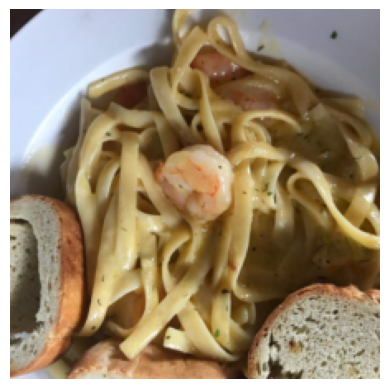

RECIPE 1

Title: Garlic shrimp scampi

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Heat olive oil in a large skillet over medium heat.
-Cook and stir garlic in hot oil until fragrant, about 1 minute.
-Stir shrimp into garlic; cook and stir until shrimp are pink and opaque, about 3 minutes.
-Season with salt and pepper.
-Stir butter into shrimp mixture until melted and sauce is heated through, about 2 minutes.
-Stir parsley into shrimp mixture; cook and stir until heated through, about 1 minute.
RECIPE 2

Title: Fettuccine with shrimp and garlic

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Bring a large pot of water to the boil.
-Meanwhile, cook pasta until al dente.
-Drain, return to pot and add butter, olive oil, and garlic.
-Cook over low heat, stirring, until butter melts.
-Season with salt and pepper.
-Toss together pasta, chopped parsley, and shrimp.
RECIPE 3

Title: Angel hair shrimp scampi

Ingre

In [11]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
        

#### CALCULATION OF SIMILARITY SCORES FOR RECIPE TITLES 

In [41]:
from sentence_transformers import SentenceTransformer, util
simmodel = SentenceTransformer('all-MiniLM-L6-v2')

def simscore(str1, str2):
    em1 = simmodel.encode(str1, convert_to_tensor=True)
    em2 = simmodel.encode(str2, convert_to_tensor=True)

    return util.cos_sim(em1, em2).item()

In [24]:
image_folder = os.path.join('../Kaggle data/images/test/')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)
demo_imgs = demo_imgs[0:5]
demo_imgs

['onion-marmalade-355800.jpg',
 'mushroom-strudel-351437.jpg',
 'jacquess-french-potato-salad-358334.jpg',
 'candied-mandarin-oranges-with-cranberries-368271.jpg',
 'ganache-for-hot-chocolate-and-mochas-51119220.jpg']

In [25]:
## get actual recipe names
import pandas as pd
recipe_names = pd.read_csv('../Kaggle data/final_data.csv')
recipe_names.head()

,id,title,ingredients,instructions,image_name,cleaned_ingredients,ingredients_rawmats,partition
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3Â½â€“4-lb.) whole chicken', '2Â¾ tsp. ko...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3Â½â€“4-lb.) whole chicken', '2Â¾ tsp. ko...","['squash', 'oil', 'apples', 'onion', 'bread', ...",train
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400Â°F and line a rimmed bakin...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (...","['pepper', 'salt', 'egg', 'potatoes']",train
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ...","['onion', 'garlic', 'pepper', 'cheese', 'chedd...",train
3,3,Italian Sausage and Bread Stuffing,"['1 (Â¾- to 1-pound) round Italian loaf, cut i...",Preheat oven to 350Â°F with rack in middle. Ge...,italian-sausage-and-bread-stuffing-240559,"['1 (Â¾- to 1-pound) round Italian loaf, cut i...","['oil', 'garlic', 'turkey', 'butter', 'eggs', ...",train
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho...","['cinnamon', 'bourbon', 'apple', 'juice', 'but...",train


In [43]:
simscores = []
counter = 0
for img_file in demo_imgs:
    print(counter)
    
    image_path = os.path.join(image_folder, img_file)
    image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)

    #plt.imshow(image_transf)
    #plt.axis('off')
    #plt.show()
    #plt.close()

    ## get ground truth recipe name
    img_name = img_file.replace(".jpg", "")
    subset = recipe_names[recipe_names['image_name'] == img_name]
    actual_title = subset.iloc[0]['title']

    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)

        if valid['is_valid'] or show_anyways:
            pred_title = outs['title']
            simscores.append(simscore(actual_title, pred_title))

    counter += 1

0
1
2
3
4
